In [1]:
import argparse, os, torch, cudaq
import openfermion, openfermionpyscf
import cudaq
import numpy as np
from pyscf import gto, scf, mcscf, ao2mo, fci, cc
import openfermion
from openfermion import MolecularData, get_fermion_operator, jordan_wigner
from openfermionpyscf import run_pyscf


parser = argparse.ArgumentParser()
parser.add_argument('--mpi', action='store_true')
args, _ = parser.parse_known_args()       

# ---- MPI / target 設定 ----
rank = 0
world = 1
if args.mpi:
    try:
        cudaq.set_target('nvidia', option='mqpu')
        if hasattr(cudaq, 'mpi') and not cudaq.mpi.is_initialized():
            cudaq.mpi.initialize()
        rank  = cudaq.mpi.rank()
        world = cudaq.mpi.num_ranks()
    except RuntimeError as e:
        print(f'Warning: {e}\nFalling back to single-process CPU/QPU...')
        args.mpi = False

if not args.mpi:
    try:
        cudaq.set_target('nvidia', option='fp64')
    except RuntimeError:
        cudaq.set_target('qpp-cpu')

import cudaq_solvers as solvers
from cudaq import spin
from lightning.fabric.loggers import CSVLogger
from cudaq_solvers.gqe_algorithm.gqe import get_default_config
# 再現性設定
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.manual_seed(3047)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/leo07010/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [128]:
MOLECULE_DATA = {
    "H2": {
        "geometry": [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.7414))],
        "basis": "sto-3g",
        "multiplicity": 1,
        "charge": 0
    },
    "N2": {
        "geometry": [("N", (0.0, 0.0, 0.0)), ("N", (0.0, 0.0, 1.0977))],
        "basis": "sto-3g",
        "multiplicity": 1,
        "charge": 0
    }
}

# ==========================================
# 1. 定義 get_pyscf_results 函式
# ==========================================
def get_pyscf_results(molecule_name, dist_scale=1.0, active_space=None):
    """
    建立分子，執行 HF/FCI/CCSD/CCSD(T)，並為指定的活躍空間建構積分和量子位元哈密頓量。
    
    Args:
        molecule_name (str): 分子名稱 (來自 MOLECULE_DATA)。
        dist_scale (float): 雙原子分子的鍵長比例。
        active_space (list[int] | tuple[int, int] | None): 
            - 如果是 list[int]: 指定要使用的活躍空間軌域索引列表 (例如 [2,3,4])。
            - 如果是 tuple[int, int]: 指定 (活躍電子數, 活躍軌域數)，例如 (10, 7)。程式會自動計算核心軌域並選取區間。
            - 如果為 None: 使用所有軌域。

    Returns:
        tuple: 包含 PySCF 分子物件、各種能量、哈密頓量算符及積分張量等資訊。
    """
    if molecule_name not in MOLECULE_DATA:
        raise ValueError(f"Molecule {molecule_name} not found in MOLECULE_DATA.")

    data = MOLECULE_DATA[molecule_name]
    geom = data['geometry']

    # 處理鍵長縮放
    if len(geom) == 2 and dist_scale != 1.0:
        atom1, pos1 = geom[0]
        atom2, pos2 = geom[1]
        scaled_pos2 = tuple([p * dist_scale for p in pos2])
        scaled_geom = [[atom1, pos1], [atom2, scaled_pos2]]
    else:
        scaled_geom = geom

    # --- PySCF 初始化 ---
    mol = gto.Mole()
    mol.atom = scaled_geom
    mol.basis = data['basis']
    mol.charge = data['charge']
    mol.spin = data['multiplicity'] - 1
    mol.build(verbose=0)

    # --- 執行 Hartree-Fock ---
    mf = scf.RHF(mol).run(verbose=0)
    hf_e = mf.e_tot

    # --- 💎 計算活躍空間積分 (Active Space Integrals) ---
    num_mos_total = mf.mo_coeff.shape[1]

    # 判斷 active_space 類型並設定 current_active_space (索引列表)
    if active_space is None:
        # None: 全空間
        current_active_space = list(range(num_mos_total))
        
    elif isinstance(active_space, tuple) and len(active_space) == 2:
        # Tuple (nelec_cas, norb_cas): 自動計算索引
        n_cas_elec, n_cas_orb = active_space
        
        n_total_elec = int(sum(mf.mo_occ))
        n_core_elec = n_total_elec - n_cas_elec
        
        if n_core_elec < 0:
             raise ValueError(f"設定的活躍電子數 ({n_cas_elec}) 超過總電子數 ({n_total_elec})")
             
        n_core_orb = n_core_elec // 2  # 假設核心軌域都是雙佔據
        
        # 檢查範圍是否合法
        if n_core_orb + n_cas_orb > num_mos_total:
             raise ValueError(f"需要的軌域數 (Core {n_core_orb} + Active {n_cas_orb}) 超過總軌域數 ({num_mos_total})")
             
        # 自動產生索引：從核心軌域之後開始算 n_cas_orb 個
        current_active_space = list(range(n_core_orb, n_core_orb + n_cas_orb))
        print(f"自動設定 Active Space Indices: {current_active_space} (Core orbitals: 0-{n_core_orb-1})")
        
    else:
        # List: 直接使用使用者提供的索引
        current_active_space = active_space

    # 1. num_orbitals
    num_orbitals = len(current_active_space)

    # 2. n_electrons (活躍空間內)
    n_electrons = int(sum(mf.mo_occ[current_active_space]))
    num_elec_a = (n_electrons + mol.spin) // 2
    num_elec_b = (n_electrons - mol.spin) // 2
    nelec = (num_elec_a, num_elec_b)

    # 3. cas
    cas = mcscf.CASCI(mf, num_orbitals, nelec)
    
    # 4. mo
    mo = cas.sort_mo(current_active_space, base=0)
    
    # 5. hcore, constant_offset
    hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)

    # 6. eri
    eri_cas = cas.get_h2eff(mo)
    eri = ao2mo.restore(1, eri_cas, num_orbitals)

    # --- 傳統方法計算 (FCI & CCSD) ---
    try:
        fci_solver = fci.FCI(mf)
        fci_e, _ = fci_solver.kernel()
    except Exception:
        fci_e = hf_e

    try:
        ccsd_solver = cc.CCSD(mf)
        ccsd_solver.kernel()
        ccsd_e = ccsd_solver.e_tot
        ccsd_t_e = ccsd_e + ccsd_solver.ccsd_t()
    except Exception:
        ccsd_e = hf_e
        ccsd_t_e = hf_e

    # --- OpenFermion 部分 ---
    mol_of = MolecularData(
        geometry=scaled_geom,
        basis=data['basis'],
        multiplicity=data['multiplicity'],
        charge=data['charge']
    )
    mol_of = run_pyscf(mol_of, run_scf=True, run_fci=False, verbose=False)
    
    all_indices = set(range(num_mos_total))
    active_set = set(current_active_space)
    core_indices = [i for i in range(num_mos_total) if i not in active_set and mf.mo_occ[i] > 0.0]

    fermion_ham = mol_of.get_molecular_hamiltonian(
        occupied_indices=core_indices,
        active_indices=current_active_space
    )
    
    fermion_op = get_fermion_operator(fermion_ham)
    qubit_ham = jordan_wigner(fermion_op)

    return (
        mol, hf_e, fci_e, ccsd_e, ccsd_t_e, qubit_ham,
        hcore, eri, nuclear_repulsion_energy, num_orbitals, nelec
    )

# ==========================================
# 2. 主程式執行區塊
# ==========================================
# 選擇分子
target_molecule = "N2" 
# target_molecule = "H2" # 切換這個可以測試 H2

if target_molecule == "N2":
    # N2 設定: (10 電子, 7 軌域)
    # 使用 tuple 格式 (nele_cas, norb_cas)
    active_space_input = (10, 7) 
elif target_molecule == "H2":
    # H2 設定: (2 電子, 2 軌域) -> 全空間
    active_space_input = None
else:
    active_space_input = None

print(f"Calculating {target_molecule} with Active Space: {active_space_input} (n_elec, n_orb)")

# 呼叫函式
(mol, hf_e, fci_e, ccsd_e, ccsd_t_e, qubit_ham_of, 
 hcore, eri, active_const, norb_cas, nele_cas_tuple) = get_pyscf_results(
    molecule_name=target_molecule,
    active_space=active_space_input
)

# 轉換為 CUDA-Q SpinOperator
spin_ham = cudaq.SpinOperator(qubit_ham_of)

# 設定後續需要的全域變數
n_qubits = norb_cas * 2
n_electrons = sum(nele_cas_tuple)

print(f"\n=== {target_molecule} Energy Summary ===")
print(f"Full HF Energy      = {hf_e:.8f} Ha")
print(f"Full FCI Energy     = {fci_e:.8f} Ha")
print(f"Full CCSD Energy    = {ccsd_e:.8f} Ha")
print(f"Active Const Offset = {active_const:.8f} Ha (Nuclear + Frozen Core)")

print("\n=== Hamiltonian Summary ===")
print(f"Number of Qubits    : {n_qubits}")
print(f"Number of Electrons : {n_electrons}")
print(f"Hamiltonian Terms   : {spin_ham.term_count}")

print("\n=== Tensor Shapes ===")
print(f"h_pq shape          : {hcore.shape}")
print(f"g_pqrs shape        : {eri.shape}")

Calculating N2 with Active Space: (10, 7) (n_elec, n_orb)
自動設定 Active Space Indices: [2, 3, 4, 5, 6, 7, 8] (Core orbitals: 0-1)

=== N2 Energy Summary ===
Full HF Energy      = -107.49589331 Ha
Full FCI Energy     = -107.65282873 Ha
Full CCSD Energy    = -107.64894129 Ha
Active Const Offset = -76.40914089 Ha (Nuclear + Frozen Core)

=== Hamiltonian Summary ===
Number of Qubits    : 14
Number of Electrons : 10
Hamiltonian Terms   : 670

=== Tensor Shapes ===
h_pq shape          : (7, 7)
g_pqrs shape        : (7, 7, 7, 7)


/tmp/ipykernel_2519516/1268176381.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
  spin_ham = cudaq.SpinOperator(qubit_ham_of)


In [129]:
# geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1.0977))]

# basis = 'sto3g'
# multiplicity = 1
# charge = 0
# ncore = 0
# nele_cas, norb_cas = (2, 2)

# molecule = openfermion.MolecularData(geometry, basis, multiplicity, charge)
# molecule = openfermionpyscf.run_pyscf(
#     molecule,
#     run_scf=1,
#     run_ccsd=1,
#     run_fci=1,  
# )


# molecular_hamiltonian = molecule.get_molecular_hamiltonian(
#     occupied_indices=range(ncore),
#     active_indices=range(ncore, ncore + norb_cas))

# fermion_hamiltonian = openfermion.get_fermion_operator(molecular_hamiltonian)

# qubit_hamiltonian = openfermion.jordan_wigner(fermion_hamiltonian)

# spin_ham = cudaq.SpinOperator(qubit_hamiltonian)

# print("=== Energy Summary ===")
# print(f"Full HF Energy      = {molecule.hf_energy:.8f} Ha")
# print(f"Full FCI Energy     = {molecule.fci_energy:.8f} Ha")

# active_const = molecular_hamiltonian.constant     
# full_fci = molecule.fci_energy                   
# frozen_core_energy = full_fci - active_const
# print(f"Frozen-core energy contribution = {frozen_core_energy:.8f} Ha")

In [130]:
# # Create the molecular hamiltonian
# geometry = [('Li', (0., 0., 0.)), ('H', (0., 0., .7474))]
# molecule = solvers.create_molecule(geometry, 'sto-3g', 0, 0, casci=True)

# spin_ham = molecule.hamiltonian
# n_qubits = molecule.n_orbitals * 2
# n_electrons = molecule.n_electrons
# print(molecule.energies)  
# print('n_qubits=',n_qubits)
# for term in spin_ham:
#     coeff = term.evaluate_coefficient()
#     pauli = term.get_pauli_word(n_qubits)
#     print(f"{coeff:.6f} * {pauli}")

In [131]:
import cudaq
import numpy as np
from cudaq import SpinOperator

# 注意：SpinOperator() 建立的是 "Zero" (空)，不是 Identity。
# 如果你想要 Identity，通常需要用 from_word 或者類似方法，但這裡我們先保留你的邏輯並加上過濾。
def get_identity(n_qubits: int) -> SpinOperator:
    return SpinOperator() 

pool = []
params = [2**k / 320 for k in range(0, 5)] + [-2**k / 320 for k in range(0, 5)]
operators = solvers.get_operator_pool("uccsd", num_qubits=n_qubits, num_electrons=n_electrons)

# 定義一個 helper 函數來檢查 Operator 是否為空
def is_valid_operator(op: SpinOperator) -> bool:
    # 使用 .term_count 屬性 (不要加括號)
    return op.term_count > 0
    
    # 方法 B: 嘗試迭代 (最通用的保險做法)
    # 如果 next(iter(op)) 拋出 StopIteration，代表它是空的
    try:
        next(iter(op))
        return True
    except StopIteration:
        return False

# 1. 處理 Identity (或 Zero)
ident = get_identity(n_qubits)
if is_valid_operator(ident):
    pool.append(ident)
else:
    print("Notice: get_identity returned an empty operator (Zero) and was skipped.")

# 2. 處理 UCCSD Operators
for o in operators:
    for p in params:
        scaled_op = p * o  # 建立 Scaled Operator
        
        # --- 在這裡判斷把空的拿掉 ---
        if is_valid_operator(scaled_op):
            pool.append(scaled_op)
        # -------------------------

op_pool = pool
print(f"Total operators in pool = {len(pool)}")

# 驗證檢查
# for i, op in enumerate(pool):
#     print(f"[{i}] {op}")

Notice: get_identity returned an empty operator (Zero) and was skipped.
Total operators in pool = 1400


In [132]:
def term_coefficients(op: cudaq.SpinOperator) -> list[complex]:
    return [term.evaluate_coefficient() for term in op]


def term_words(op: cudaq.SpinOperator) -> list[cudaq.pauli_word]:
    return [term.get_pauli_word(n_qubits) for term in op]

# Kernel that applies the selected operators
@cudaq.kernel
def kernel(n_qubits: int, n_electrons: int, coeffs: list[float],
           words: list[cudaq.pauli_word]):
    q = cudaq.qvector(n_qubits)

    for i in range(n_electrons):
        x(q[i])

    for i in range(len(coeffs)):
        exp_pauli(coeffs[i], q, words[i])


def cost(sampled_ops: list[cudaq.SpinOperator], **kwargs):

    full_coeffs = []
    full_words = []

    for op in sampled_ops:
        full_coeffs += [c.real for c in term_coefficients(op)]
        full_words += term_words(op)

    if args.mpi:
        handle = cudaq.observe_async(kernel,
                                     spin_ham,
                                     n_qubits,
                                     n_electrons,
                                     full_coeffs,
                                     full_words,
                                     qpu_id=kwargs['qpu_id'])
        return handle, lambda res: res.get().expectation()
    else:
        return cudaq.observe(kernel, spin_ham, n_qubits, n_electrons,
                             full_coeffs, full_words).expectation()

In [135]:
# Configure GQE
cfg = get_default_config()
cfg.use_fabric_logging = False
cfg.max_iters = 100
logger = CSVLogger("gqe_h2_logs/gqe.csv")
cfg.fabric_logger = logger
cfg.save_trajectory = False 
cfg.verbose = True
cfg.small = False
cfg.energy_offset = 106.0
cfg.temperature = 1
cfg.lr = 1e-4

In [136]:
# Run GQE
from GQE_tool.gqe import gqe
minE, best_ops = gqe(cost, op_pool, max_iters=10, ngates=20, config=cfg)

Seed set to 3047


total trainable params: 86.92M
epoch 0 loss tensor(9.6810, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.30402612686157227 tensor(-107.4915)
epoch 1 loss tensor(6.9811, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.29857563972473145 tensor(-107.4845)
epoch 2 loss tensor(5.2610, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.2995319366455078 tensor(-107.4930)
epoch 3 loss tensor(1807.3453, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3030245304107666 tensor(-107.4474)
epoch 4 loss tensor(4.8147, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.29761767387390137 tensor(-107.5048)
epoch 5 loss tensor(3.3717, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.2969386577606201 tensor(-107.4926)
epoch 6 loss tensor(1.8577, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.29798078536987305 tensor(-107.4956)
epoch 7 loss tensor(0.8445, dev

In [137]:
# Only print results from rank 0 when using MPI
if not args.mpi or cudaq.mpi.rank() == 0:
    print(f'Ground Energy = {minE}')
    print('Ansatz Ops')
    for idx in best_ops:
        # Get the first (and only) term since these are simple operators
        term = next(iter(op_pool[idx]))
        print(term.evaluate_coefficient().real, term.get_pauli_word(n_qubits))

if args.mpi:
    cudaq.mpi.finalize()

Ground Energy = -107.51065826416016
Ansatz Ops
0.0015625 IIXXIIIIIIXZZY
-0.000390625 IIIXZZZZXIIXYI
0.003125 IIIIIIXXIIIXYI
-0.000390625 IIIIXXIIIIXZZY
-0.00078125 IIIIIIIIXXXZZY
0.003125 IIXZZZXIIIXZYI
-0.00078125 IIIIXXIIIIIXYI
-0.003125 IIIIIXZZXIXZZY
0.0015625 IIIIXZZXIIXZZY
0.003125 IIIIXZXIIIXZYI
0.003125 IIIXZZZZXIIIXY
-0.025 IIIIIYZZZZZXII
0.003125 IIIIXZXIIIXZYI
-0.000390625 IIIXZZZZXIIXYI
0.003125 IIIIXZXIIIXZYI
0.00078125 XZZZZXIIIIXZZY
0.00078125 IIXZZZXIIIXZYI
0.003125 IXZZZZXIIIIXYI
-0.000390625 IIIIIIXZZXXYII
0.003125 IIIIXZXIIIXZYI


=== Starting Sweep for lr ===

Running with lr = 0.001


Seed set to 3047


total trainable params: 86.92M
epoch 0 loss tensor(0.4556, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3257558345794678 tensor(-107.4851)
epoch 1 loss tensor(2078.2605, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.31892991065979004 tensor(-107.4298)
epoch 2 loss tensor(0.3691, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3127734661102295 tensor(-107.4891)
epoch 3 loss tensor(1.8167e+09, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3182506561279297 tensor(-107.3593)
epoch 4 loss tensor(267364.9688, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.30689311027526855 tensor(-107.4937)
epoch 5 loss tensor(5346.1709, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3176579475402832 tensor(-107.3036)
epoch 6 loss tensor(461.8869, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3103804588317871 tensor(-107.4768)
epoch 7 loss tensor

Seed set to 3047


total trainable params: 86.92M
epoch 0 loss tensor(0.4556, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.33182358741760254 tensor(-107.4851)
epoch 1 loss tensor(589.6943, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.32665252685546875 tensor(-107.4254)
epoch 2 loss tensor(1.9331, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3209414482116699 tensor(-107.4511)
epoch 3 loss tensor(1.7309, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3202052116394043 tensor(-107.4873)
epoch 4 loss tensor(28199.1348, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3233160972595215 tensor(-107.3943)
epoch 5 loss tensor(10481.5342, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3141615390777588 tensor(-107.3077)
epoch 6 loss tensor(124.3686, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.31334447860717773 tensor(-107.4735)
epoch 7 loss tensor(175

Seed set to 3047


total trainable params: 86.92M
epoch 0 loss tensor(0.4556, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.33405113220214844 tensor(-107.4851)
epoch 1 loss tensor(62.6909, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.32781505584716797 tensor(-107.4583)
epoch 2 loss tensor(5.7108, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.32176828384399414 tensor(-107.4910)
epoch 3 loss tensor(0.0749, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.31924867630004883 tensor(-107.4922)
epoch 4 loss tensor(0.2938, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3215155601501465 tensor(-107.5043)
epoch 5 loss tensor(0.6736, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3218650817871094 tensor(-107.4924)
epoch 6 loss tensor(0.1053, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3268709182739258 tensor(-107.4922)
epoch 7 loss tensor(2.1157, devic

/tmp/ipykernel_2519516/3677365917.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


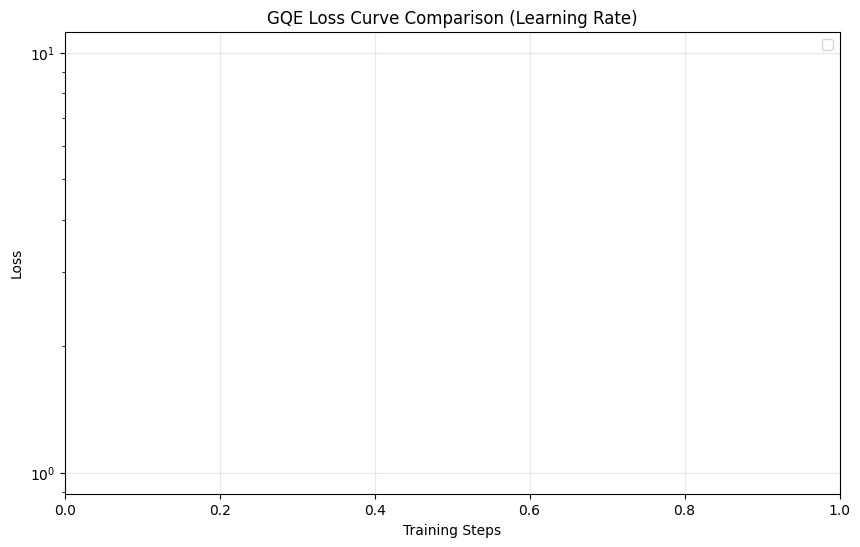

In [179]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from lightning.fabric.loggers import CSVLogger

# 確保 GQE 相關設定已經載入 (cfg, op_pool, cost, gqe 等)

def run_parameter_sweep(param_name, param_values):
    """
    執行參數掃描實驗 (修正版：強制開啟 Logging)
    """
    log_paths = {}
    
    print(f"=== Starting Sweep for {param_name} ===")
    
    # 💎 關鍵修正：確保 GQE 會寫入 Log
    cfg.use_fabric_logging = True 
    
    for val in param_values:
        print(f"\nRunning with {param_name} = {val}")
        
        # 1. 修改 Config
        setattr(cfg, param_name, val)
        
        # 2. 設定獨立的 Logger
        # 目錄結構: experiments_logs/gqe_sweep/{version_name}/metrics.csv
        version_name = f"{param_name}_{val}"
        save_dir = "experiments_logs"
        exp_name = "gqe_sweep"
        
        # 建立 Logger
        logger = CSVLogger(save_dir, name=exp_name, version=version_name)
        cfg.fabric_logger = logger
        
        # 3. 執行 GQE
        # 我們只跑 50-100 iters 就足夠觀察趨勢了
        gqe(cost, op_pool, max_iters=100, ngates=20, config=cfg)
        
        # 4. 尋找並記錄 Log 檔案位置
        # 有時候 Lightning 會多一層 version_0 目錄，我們用 glob 自動尋找比較保險
        search_pattern = os.path.join(save_dir, exp_name, version_name, "**/metrics.csv")
        found_files = glob.glob(search_pattern, recursive=True)
        
        if found_files:
            log_paths[val] = found_files[0] # 取第一個找到的
            print(f"Log saved at: {found_files[0]}")
        else:
            # 備用路徑猜測
            fallback_path = os.path.join(save_dir, exp_name, version_name, "metrics.csv")
            log_paths[val] = fallback_path
            print(f"Warning: File not immediately found via glob. Assume path: {fallback_path}")
        
    return log_paths

def plot_loss_curves(log_paths, param_name):
    plt.figure(figsize=(10, 6))
    
    for val, path in log_paths.items():
        if os.path.exists(path):
            try:
                df = pd.read_csv(path)
                # 繪製 loss (過濾掉 NaN)
                if 'loss' in df.columns:
                    data = df['loss'].dropna().reset_index(drop=True)
                    plt.plot(data, label=f"{param_name}={val}")
            except Exception as e:
                print(f"Error reading {path}: {e}")
        else:
            print(f"File still not found: {path}")
            
    plt.title(f"GQE Loss Curve Comparison ({param_name})")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log') # 對數座標看差異更清楚
    plt.show()

# === 執行實驗 ===
# 測試三種 Learning Rate
lr_values = [1e-3, 1e-4, 1e-5]

# 執行掃描
lr_logs = run_parameter_sweep('lr', lr_values)

# 畫圖
plot_loss_curves(lr_logs, 'Learning Rate')

=== Starting Sweep for temperature ===

Running with temperature = 0.1


Seed set to 3047


total trainable params: 86.92M
epoch 0 loss tensor(11.5091, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3201131820678711 tensor(-107.4996)
epoch 1 loss tensor(10.1792, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3143284320831299 tensor(-107.4829)
epoch 2 loss tensor(9.9120, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.31846189498901367 tensor(-107.4928)
epoch 3 loss tensor(9.5947, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3180544376373291 tensor(-107.4799)
epoch 4 loss tensor(9.3684, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3213789463043213 tensor(-107.5036)
epoch 5 loss tensor(8.6540, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.31772375106811523 tensor(-107.4945)
epoch 6 loss tensor(7.3296, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3198113441467285 tensor(-107.4853)
epoch 7 loss tensor(7.2416, device

Seed set to 3047


total trainable params: 86.92M
epoch 0 loss tensor(9.6810, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3213522434234619 tensor(-107.4915)
epoch 1 loss tensor(6.9811, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3310549259185791 tensor(-107.4845)
epoch 2 loss tensor(5.2610, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.32577967643737793 tensor(-107.4930)
epoch 3 loss tensor(1807.3453, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3230628967285156 tensor(-107.4474)
epoch 4 loss tensor(4.8147, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.32140564918518066 tensor(-107.5048)
epoch 5 loss tensor(3.3717, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.32398438453674316 tensor(-107.4926)
epoch 6 loss tensor(1.8577, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3233211040496826 tensor(-107.4956)
epoch 7 loss tensor(0.8445, devi

Seed set to 3047


total trainable params: 86.92M
epoch 0 loss tensor(0.4556, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.34794020652770996 tensor(-107.4851)
epoch 1 loss tensor(589.6943, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3389749526977539 tensor(-107.4254)
epoch 2 loss tensor(1.9331, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3418464660644531 tensor(-107.4511)
epoch 3 loss tensor(1.7309, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3381693363189697 tensor(-107.4873)
epoch 4 loss tensor(28199.1348, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.34473133087158203 tensor(-107.3943)
epoch 5 loss tensor(10481.5342, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.3391120433807373 tensor(-107.3077)
epoch 6 loss tensor(124.3686, device='cuda:0', grad_fn=<MseLossBackward0>) model.train_step time: 0.32923388481140137 tensor(-107.4735)
epoch 7 loss tensor(175

/tmp/ipykernel_2519516/3677365917.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


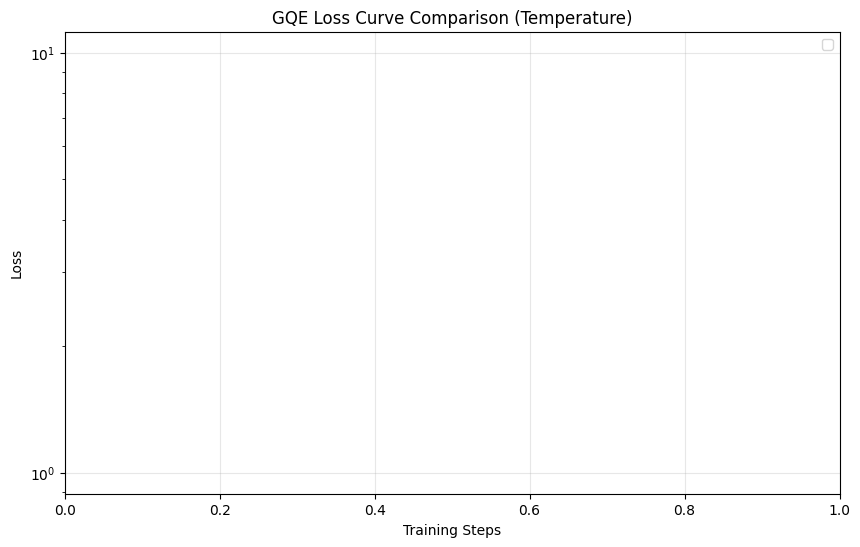

In [180]:
# === 設定實驗參數 ===
temp_values = [0.1, 1.0, 5.0]

# 恢復預設 LR
cfg.lr = 1e-4
cfg.max_iters = 100

# === 執行掃描 ===
temp_logs = run_parameter_sweep('temperature', temp_values)

# === 畫圖 ===
plot_loss_curves(temp_logs, 'Temperature')

## SQD

In [167]:
if not args.mpi or cudaq.mpi.rank() == 0:
    final_coeffs = []
    final_words = []
    for idx in best_ops:
        op = op_pool[idx]
        final_coeffs += [c.real for c in term_coefficients(op)]
        final_words += term_words(op)

    energy_result = cudaq.observe(kernel, spin_ham, n_qubits, n_electrons, final_coeffs, final_words)
    ground_energy = energy_result.expectation()
    # total_energy = ground_energy + nuclear_repulsion_energy
    
    print(f"Calculated Ground Energy: {ground_energy}")
    # ---------------------------------------------------------

    # 2. 執行採樣 (為了給 SQD 用)
    sample_result = cudaq.sample(kernel, n_qubits, n_electrons, final_coeffs, final_words, shots_count=10000)
    config_counts = dict(sample_result.items())

    print(config_counts)

Calculated Ground Energy: -107.51065919192828
{'11001111111001': 1, '11110011111001': 1, '11110110111001': 4, '11111011011001': 4, '10111101110110': 4, '11111100110110': 4, '11110101111010': 90, '11101111010011': 2, '11111011110100': 26, '11011101111010': 9, '11111111110000': 9855}


In [175]:
def get_spin_ordered_results(counts):
    """
    僅改變 Bitstring 的順序，不進行任何過濾。
    輸入格式 (Big Endian): qN...q0 (其中 q0, q1 為第一個軌域的 alpha, beta)
    輸出格式: "Down_Part + Up_Part" (即 "1下 2下 ... 1上 2上 ...")
    """
    ordered_dict = {}
    
    for config, count in counts.items():
        # 1. 反轉字串以取得 Little Endian (q0, q1, q2...)
        #    q0: Orb 0 Up
        #    q1: Orb 0 Down
        #    q2: Orb 1 Up
        #    q3: Orb 1 Down
        rconfig = config[::-1]
        
        # 2. 提取 Up 部分 (偶數索引 0, 2, 4...) -> 對應 1上, 2上, 3上...
        up_part = rconfig[0::2]
        
        # 3. 提取 Down 部分 (奇數索引 1, 3, 5...) -> 對應 1下, 2下, 3下...
        down_part = rconfig[1::2]
        
        # 4. 組合新的 Key (修改處：左邊是 Down, 右邊是 Up)
        new_key = down_part + up_part
        
        # 5. 存入字典
        ordered_dict[new_key] = count
        
    return ordered_dict

# 測試輸出
# 假設 config_counts 已經定義
final_conserved_dict = get_spin_ordered_results(config_counts)
print(f"Original: {config_counts}")
print(f"Reordered: {final_conserved_dict}")
print("(Format: Left=Down Spins, Right=Up Spins)")

Original: {'11001111111001': 1, '11110011111001': 1, '11110110111001': 4, '11111011011001': 4, '10111101110110': 4, '11111100110110': 4, '11110101111010': 90, '11101111010011': 2, '11111011110100': 26, '11011101111010': 9, '11111111110000': 9855}
Reordered: {'01111011011101': 1, '01110111011011': 1, '01110111010111': 4, '01011111011011': 4, '10101110111110': 4, '10101110110111': 4, '11100110011111': 90, '10011111011101': 2, '00111110111011': 26, '11101010011111': 9, '00111110011111': 9855}
(Format: Left=Down Spins, Right=Up Spins)


In [171]:
from qiskit_addon_sqd.counts import BitArray
bitstrings = list(final_conserved_dict.keys())
bitvalues = [int(b, 2) for b in bitstrings]

# 根據出現次數生成對應的數據
samples = []
for bitstring, count in final_conserved_dict.items():
    samples.extend([int(bitstring, 2)] * count)  # 重複出現的數字

# 找出 num_bits
num_bits = len(bitstrings[0])  # 假設所有的 bit 字串長度相同

# 將這些整數數據打包為 uint8 陣列
num_bytes = (num_bits + 7) // 8  # 每個 bit 字串的大小（以字節計算）

# 轉換為二進位字節串
data = b"".join(val.to_bytes(num_bytes, "big") for val in samples)
array = np.frombuffer(data, dtype=np.uint8)

# 假設你已經有 BitArray 類別（如前面提供的代碼）
# 你可以將這個數據轉換為 BitArray 類型
bit_array = BitArray(array.reshape(-1, num_bytes), num_bits=num_bits)

# 輸出結果
print(bit_array)

BitArray(<shape=(), num_shots=10000, num_bits=14>)


In [172]:
from functools import partial
 
from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)
 
# SQD options
energy_tol = 1e-6
occupancies_tol = 1e-6
max_iterations = 5
 
# Eigenstate solver options
num_batches = 3
samples_per_batch = 100
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200
 
# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)
 
# List to capture intermediate results
result_history = []
 
 
def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )
 
 
result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    bit_array,
    samples_per_batch=samples_per_batch,
    norb=norb_cas,
    nelec=nele_cas_tuple,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

Iteration 1
	Subsample 0
		Energy: -29.96039077355908
		Subspace dimension: 36
	Subsample 1
		Energy: -29.96039077355908
		Subspace dimension: 36
	Subsample 2
		Energy: -29.96039077355908
		Subspace dimension: 36
Iteration 2
	Subsample 0
		Energy: -30.671133202052054
		Subspace dimension: 81
	Subsample 1
		Energy: -30.671133202052054
		Subspace dimension: 81
	Subsample 2
		Energy: -30.671133202052054
		Subspace dimension: 81
Iteration 3
	Subsample 0
		Energy: -30.67781262445968
		Subspace dimension: 169
	Subsample 1
		Energy: -30.67781262445968
		Subspace dimension: 169
	Subsample 2
		Energy: -30.67781262445968
		Subspace dimension: 169
Iteration 4
	Subsample 0
		Energy: -30.67781262445968
		Subspace dimension: 169
	Subsample 1
		Energy: -30.67781262445968
		Subspace dimension: 169
	Subsample 2
		Energy: -30.67781262445968
		Subspace dimension: 169
